In [1]:
import pandas as pd  # For dataframe
import numpy as np  # For matrix operations
import sklearn.preprocessing as sklpre  # For preprocessing (scaling)
import sklearn.linear_model as skllm  # For OLS
import sklearn.model_selection as sklms  # For train_test_split
from scipy import stats  # To calc p-value
import matplotlib.pyplot as plt  # For plotting
import pygam  # For generalized additive models
import sklearn.ensemble as sklen  # For ensemble methods

# For automatic formatting of code, sparing you from my usually horrible looking code
%load_ext nb_black

<IPython.core.display.Javascript object>

# Task 1.1
I have chosen to one-hot encode the SEX-category, as neither male nor female should be considered adifferent numbers. 
The rest of the categorical values are just true/false, so those aren't encoded. 
Then I scale all the scalar features, not touching the categorical features.

In [2]:
# Reading the data into dataframe
df = pd.read_csv("data_task_1.txt", header=0, sep=" ")
# Onehot-encoding gender
onehot_gender = pd.get_dummies(df["SEX"]).set_axis(
    ["Male", "Female"], axis=1, inplace=False
)
# Replacing old gender column
df = df.join(onehot_gender)
df.drop("SEX", axis=1, inplace=True)
# List of boolean categories
categorical = [
    "ADHEU",
    "HOCHOZON",
    "AMATOP",
    "AVATOP",
    "ADEKZ",
    "ARAUCH",
    "FSNIGHT",
    "FSPT",
    "FSATEM",
    "FSAUGE",
    "FSPFEI",
    "FSHLAUF",
    "Male",
    "Female",
]

# A loop that splits the data and tries again until there is no split where only one modality is in one split
first = True
while (
    first
    or np.any(
        np.logical_or(X_train.sum(axis=0) == 0, X_train.sum(axis=0) == X_train.shape[0])
    )
    or np.any(
        np.logical_or(X_test.sum(axis=0) == 0, X_test.sum(axis=0) == X_test.shape[0])
    )
):
    first = False
    # Splitting over and over until splits are good, stratifying the most biased feature.
    X_train, X_test, y_train, y_test = sklms.train_test_split(
        df.loc[:, df.columns != "FFVC"],
        df["FFVC"],
        test_size=0.5,
        stratify=df["FSATEM"],
    )
# Scaling scalar features based on train set
scaler = sklpre.StandardScaler()
X_train_continous = scaler.fit_transform(
    X_train.loc[:, np.logical_not(np.isin(X_train.columns, categorical))].values
)
X_test_continous = scaler.transform(
    X_test.loc[:, np.logical_not(np.isin(X_test.columns, categorical))].values
)
# Putting all scalar and categorical features together
X_train.loc[
    :, np.logical_not(np.isin(X_train.columns, categorical))
] = X_train_continous
X_test.loc[:, np.logical_not(np.isin(X_test.columns, categorical))] = X_test_continous
# Need to specify datatypes because it chose a dumb datatype by default
X_train = X_train.astype({"Male": "int32", "Female": "int32"})
X_test = X_test.astype({"Male": "int32", "Female": "int32"})
# All preprocessing done!

<IPython.core.display.Javascript object>

# Task 1.2
Running OLS, calculating uncertainties and p-values

In [3]:
def get_summary_linear_model(model, X_train, y_train):
    """
    Scikit-learn has no built in support for confidence intervals and p-values, so I 
    made this to calculate it for me after fitting the model. Put into a function for reuse.
    """
    # Combining intercept and coefficients in same array
    coefficients = np.append(model.intercept_, model.coef_)

    # Predicting y
    y_hat = model.predict(X_train)
    # Calculating RSS to get variance for use when calculating stddev of coeffs
    residuals = y_train.values - y_hat
    rss = residuals.reshape(-1, 1).T @ residuals.reshape(-1, 1)
    var = rss[0, 0] / (len(X_train) - len(X_train.columns) - 1)

    # Adding intercept to X_train, as sklearn usually does not need the column of 1's
    X_with_intercept = np.append(
        np.ones(X_train.shape[0]).reshape(-1, 1), X_train, axis=1
    )
    # Stddev of coefficients
    stddev = np.sqrt(
        (np.diag(var * np.linalg.pinv(X_with_intercept.T @ X_with_intercept)))
    )
    labels = ["Intercept"] + X_train.columns.tolist()

    coef_over_std = coefficients / stddev
    p_values = [
        2 * (1 - stats.t.cdf(np.abs(i), (len(X_with_intercept) - 1)))
        for i in coef_over_std
    ]

    # Putting results into table
    coeffs_table = pd.DataFrame(zip(labels, coefficients, stddev, p_values))
    # Giving nice names with TeX formatting
    coeffs_table.rename(
        columns={0: "Feature", 1: r"$\beta_i$", 2: r"$\pm$", 3: "p-values"},
        inplace=True,
    )
    return coeffs_table

<IPython.core.display.Javascript object>

In [4]:
# OLS on train data
ols_reg = skllm.LinearRegression().fit(X_train, y_train)
# R2 score
r2 = ols_reg.score(X_test, y_test)
coeffs_table = get_summary_linear_model(ols_reg, X_train, y_train)
most_important = coeffs_table["Feature"].values[1:][
    np.argmin(coeffs_table["p-values"].values[1:])
]
# Printing results
print(f"Got an R^2 score of {r2:.2f} for the test set.")
print(f"The most important feature (lowest p-value) is {most_important}.")
coeffs_table

Got an R^2 score of 0.61 for the test set.
The most important feature (lowest p-value) is FLGROSS.


,Feature,$\beta_i$,$\pm$,p-values
0,Intercept,2.279162,0.025880,0.000000e+00
1,ALTER,0.024455,0.015454,1.148191e-01
2,ADHEU,-0.006807,0.055130,9.018309e-01
3,HOCHOZON,-0.045373,0.038208,2.361558e-01
4,AMATOP,-0.019337,0.031600,5.411400e-01
5,AVATOP,0.003409,0.030838,9.120550e-01
6,ADEKZ,0.015160,0.034767,6.631731e-01
7,ARAUCH,0.052401,0.029463,7.654758e-02
8,AGEBGEW,0.004565,0.014322,7.502093e-01
9,FSNIGHT,-0.011067,0.046969,8.139219e-01


<IPython.core.display.Javascript object>

The most important (lower p-value) feature seems to be FLGROSS. Some other important features seem to be gender. Male and female seem to completely cancel each other, implying that men are of higher risk?

# Task 1.3
Scikit-learn for some reason doesn't have built in forward and backward selection, so I will create my own functions!

In [5]:
def backward_elimination(regressor, X_train, y_train, max_p_limit):
    """
    Takes a regressor, training set and a max p-value, runs backward
    elimination and returns the regresson fitted on the reduced
    features, the reduced feature matrix, a table of betas, 
    standard deviations and p-values and the removed features
    """
    # Fitting regressor on full model
    regressor.fit(X_train, y_train)
    # Getting table of p-values to find what to eliminate
    result_table = get_summary_linear_model(regressor, X_train, y_train)
    p_values = result_table["p-values"].values
    p_val_max, p_val_max_pos = p_values[1:].max(), p_values[1:].argmax() + 1
    # Getting name of feature with highest p-val to make list of removed features
    feature_max_p_val = result_table["Feature"][p_val_max_pos]
    removed_features = [feature_max_p_val]
    # Dropping feature with highest p-val
    X_reduce = X_train.drop(columns=feature_max_p_val, inplace=False)
    # Running backwards elimination until all p-values are below limit
    while p_val_max > max_p_limit:
        # Fitting on reduced model
        regressor.fit(X_reduce, y_train)
        result_table = get_summary_linear_model(regressor, X_reduce, y_train)
        p_values = result_table["p-values"].values
        p_val_max, p_val_max_pos = p_values[1:].max(), p_values[1:].argmax() + 1
        feature_max_p_val = result_table["Feature"][p_val_max_pos]
        # If one or more features have to high p-value, remove
        if p_val_max > max_p_limit:
            # Append name to list that keeps track of removed features
            removed_features.append(feature_max_p_val)
            # Dropping feature
            X_reduce.drop(columns=feature_max_p_val, inplace=True)
            # Sorting features
            X_reduce.sort_index(axis=1, inplace=True)
            # Fitting reduced model
            regressor.fit(X_reduce, y_train)

    return regressor, X_reduce, result_table, removed_features

<IPython.core.display.Javascript object>

In [6]:
# Model to send in to function. It is an OLS regressor.
base_regressor = skllm.LinearRegression()
# Running backwards elimination
(
    regressor_reduced,
    X_reduce_train,
    result_table_reduced,
    removed_features,
) = backward_elimination(base_regressor, X_train, y_train, max_p_limit=1e-2)
# Using list of reduced features to also create test feature matrix with same features
X_reduce_test = X_test.drop(columns=removed_features).sort_index(axis=1)
# Printing results
print(
    f"R^2 score of full model: {ols_reg.score(X_test, y_test):.2f} Backward Model: {regressor_reduced.score(X_reduce_test, y_test):.2f}"
)
result_table_reduced

R^2 score of full model: 0.61 Backward Model: 0.61


,Feature,$\beta_i$,$\pm$,p-values
0,Intercept,2.264836,0.008526,0.000000e+00
1,FLGEW,0.108312,0.018124,7.936228e-09
2,FLGROSS,0.159288,0.018220,2.220446e-16
3,FMILB,-0.034687,0.012805,7.223948e-03
4,Female,-0.095073,0.013759,4.102785e-11
5,Male,0.095073,0.013429,1.495382e-11


<IPython.core.display.Javascript object>

In [7]:
def forward_selection(regressor, X_train, y_train, max_p_limit):
    """
    Takes a regressor, training set and a max p-value, runs forward
    selection and returns the regresson fitted on the reduced
    features, the reduced feature matrix, a table of betas, 
    standard deviations and p-values and the removed features
    """
    X_null = pd.DataFrame({"null": np.zeros_like(y_train)})
    regressor.fit(X_null, y_train)
    # The p-value for the 0-column is invalid, but also not used, so I ignore the warnings
    with np.errstate(invalid="ignore"):
        # Getting results for null-model
        result_table = get_summary_linear_model(regressor, X_null, y_train)
    # p-value for intercept
    p_val_max = result_table["p-values"][0]
    # Dataframe used for incresing
    X_increased = pd.DataFrame()
    # List of features
    features = X_train.columns.values
    # while max p-val is below threshold, repeat
    while p_val_max < max_p_limit:
        # Set best p to infinity so that all values are less
        best_p = np.inf
        # Looping over features
        for feature in features:
            # Creating new column with feature in loop
            new_col = pd.DataFrame({feature: X_train[feature].values})
            # If null model we need to append to the dataframe differently than usual
            if len(X_increased.values) == 0:
                # Adding new feature to null model
                X_candidate = X_increased.append(new_col)
            else:
                # Adding new feature to model
                new_col_names = np.append(
                    X_increased.columns.values, new_col.columns.values
                )
                X_candidate = pd.DataFrame(
                    np.append(X_increased.values, new_col.values, axis=1),
                    columns=new_col_names,
                )
            # Fitting increased model to find p-value
            regressor.fit(X_candidate, y_train)
            result_table = get_summary_linear_model(regressor, X_candidate, y_train)
            p_i = result_table["p-values"].values[-1]
            # This if-statement is used to find the minimum p-value of the potential features to add
            if p_i < best_p:
                best_p = p_i
                best_new_feature = feature
        # Now that we have the best feature to add, we add it properly
        new_col = pd.DataFrame({best_new_feature: X_train[best_new_feature].values})
        if len(X_increased.values) == 0:
            X_candidate = X_increased.append(new_col)
        else:
            new_col_names = np.append(
                X_increased.columns.values, new_col.columns.values
            )
            X_candidate = pd.DataFrame(
                np.append(X_increased.values, new_col.values, axis=1),
                columns=new_col_names,
            )
        # Get results for new model
        result_table = get_summary_linear_model(regressor, X_candidate, y_train)
        p_val_max = result_table["p-values"].values.max()

        # Sorting features
        X_increased = X_candidate.sort_index(axis=1)
        # Removing added feature from list of potential featues so that we can't add it again next iteration
        features = features[features != best_new_feature]

    # List of omitted features
    omitted_features = features
    # Fitting increased model
    regressor.fit(X_increased, y_train)
    # Table of results for best model
    result_table_best = get_summary_linear_model(regressor, X_increased, y_train)
    return regressor, X_increased, result_table_best, omitted_features

<IPython.core.display.Javascript object>

In [8]:
# Model to send in to function. It is an OLS regressor.
base_regressor = skllm.LinearRegression()
# Running forward selection
(
    regressor_increased,
    X_increased_train,
    result_table_increased,
    omitted_features_increased,
) = forward_selection(base_regressor, X_train, y_train, max_p_limit=1e-2)
# Using list of reduced features to also create test feature matrix with same features
X_increased_test = X_test.drop(columns=omitted_features_increased).sort_index(axis=1)
# Printing results
print(
    f"R^2 score of forward model: {regressor_increased.score(X_increased_test, y_test):.2f}"
)
result_table_increased

R^2 score of forward model: 0.62


,Feature,$\beta_i$,$\pm$,p-values
0,Intercept,2.264914,0.008636,0.000000e+00
1,FLGEW,0.107345,0.018355,1.567557e-08
2,FLGROSS,0.159222,0.018456,8.881784e-16
3,Female,-0.093122,0.013918,1.475524e-10
4,Male,0.093122,0.013584,5.666245e-11


<IPython.core.display.Javascript object>

For the reduced models with $p_\text{max}=0.01$, both forward and backward selection give the exact same model, and therefore the same features. They also get a slightly better $R^2$-score, possibly because they have less features, and are therefore less likely to overfit on the training data. I chose to look at $R^2$ instead of MSE as I feel it is a more intuitive value. However, higher $R^2$ also implies lower MSE, so the models are better.

Next I will test with a less strict $p_\text{max}=0.1$ and see how the models perform:

In [9]:
# Model to send in to function. It is an OLS regressor.
base_regressor = skllm.LinearRegression()
# Running backwards elimination
(
    regressor_reduced_less_strict,
    X_reduce_train_less_strict,
    result_table_reduced_less_strict,
    removed_features_less_strict,
) = backward_elimination(base_regressor, X_train, y_train, max_p_limit=1e-1)
# Using list of reduced features to also create test feature matrix with same features
X_reduce_test_less_strict = X_test.drop(
    columns=removed_features_less_strict
).sort_index(axis=1)
# Printing results
print(
    f"R^2 score of full model: {ols_reg.score(X_test, y_test):.2f}"
    + f" Backward Model: {regressor_reduced_less_strict.score(X_reduce_test_less_strict, y_test):.2f}"
)
result_table_reduced_less_strict

R^2 score of full model: 0.61 Backward Model: 0.61


,Feature,$\beta_i$,$\pm$,p-values
0,Intercept,2.243071,0.010463,0.000000e+00
1,ALTER,0.027217,0.014336,5.879447e-02
2,ARAUCH,0.046795,0.027438,8.935646e-02
3,FLGEW,0.105783,0.018192,1.869909e-08
4,FLGROSS,0.149359,0.019675,6.485923e-13
5,FMILB,-0.034684,0.012780,7.118464e-03
6,FSPFEI,0.116177,0.055254,3.651176e-02
7,Female,-0.093159,0.013939,1.543379e-10
8,Male,0.093159,0.013645,6.667755e-11


<IPython.core.display.Javascript object>

In [10]:
# Model to send in to function. It is an OLS regressor.
base_regressor = skllm.LinearRegression()
# Running forward selection
(
    regressor_increased_less_strict,
    X_increased_train_less_strict,
    result_table_increased_less_strict,
    omitted_features_increased_less_strict,
) = forward_selection(base_regressor, X_train, y_train, max_p_limit=1e-1)
# Using list of reduced features to also create test feature matrix with same features
X_increased_test_less_strict = X_test.drop(
    columns=omitted_features_increased_less_strict
).sort_index(axis=1)
# Printing results
print(
    f"R^2 score of forward model: {regressor_increased_less_strict.score(X_increased_test_less_strict, y_test):.2f}"
)
result_table_increased_less_strict

R^2 score of forward model: 0.62


,Feature,$\beta_i$,$\pm$,p-values
0,Intercept,2.264914,0.008636,0.000000e+00
1,FLGEW,0.107345,0.018355,1.567557e-08
2,FLGROSS,0.159222,0.018456,8.881784e-16
3,Female,-0.093122,0.013918,1.475524e-10
4,Male,0.093122,0.013584,5.666245e-11


<IPython.core.display.Javascript object>

Now the models are not the same anymore. This is to be expected, as the p-values estimated are not the same for each feature independent of the other features. The backward elimination model seems to give a better $R^2$-score this time.

# Task 1.4
CV is easily implemented in Scikit-Learn. Bootstap on the other hand... I need to create my own class (Maybe there is a better way of doing this than what I'm doing...)

In [11]:
# 5-fold cross validation, n-jobs=-1 is for parallelisation (use multiple cpu cores)
lasso_cv = skllm.LassoCV(n_jobs=-1, cv=5).fit(X_train, y_train)
# List of hyperparameters
lambdas_lasso_cv = lasso_cv.alphas_
# List of validation mean squared errors. Need to average them over axis 1 to get average across all 5 folds
mses_lasso_cv = lasso_cv.mse_path_.mean(axis=1)
print(
    f"Best hyperparameter is {lasso_cv.alpha_:.2e}, giving a test R^2 score of {lasso_cv.score(X_test, y_test):.2f}"
)

Best hyperparameter is 5.31e-03, giving a test R^2 score of 0.61


<IPython.core.display.Javascript object>

This seems to be very similar to forward and backward selection. Now I need to make a new class for bootstrap manually implemented.

In [12]:
class Bootstrap:
    def __init__(self, y):
        """
        I was sort of confused on how to this, so I just made a class and tried stuff. 
        Now it works, so I won't change it anymore.
        This class takes y_train and saves its length.
        """
        self.len_y = len(y)

    @property
    def get_bootstrap(self):
        """
        This method returns one train-validation bootstrap split of the training data (indices of the data).
        The @property is just so that i can call get_bootstrap without the () after (like in get_bootstrap()).
        This splits train and validation into 2/3, 1/3 of the length of the data. Not sure if that is the correct
        method.
        """
        # All indices (0-lenght of y)
        indices = np.arange(self.len_y)
        # Picking random indices with replacement.
        indices_train = np.random.choice(
            indices, replace=True, size=int(self.len_y * 0.67)
        )
        indices_validate = np.random.choice(
            indices, replace=True, size=int(self.len_y * 0.37)
        )
        # Returns a list of lists
        return [indices_train.tolist(), indices_validate.tolist()]


# Creating instance of Bootstrap class
bootstrap = Bootstrap(y_train)
splits = []
# This loops creates 100 different bootstrap samples
for i in range(100):
    splits.append(bootstrap.get_bootstrap)
# Running LassoCV with bootstrap instead of CV.
lasso_bootstrap = skllm.LassoCV(n_jobs=-1, cv=splits).fit(X_train, y_train)

# Lambdas tried by the solver
lambdas_lasso_bootstrap = lasso_bootstrap.alphas_
# List of validation mean squared errors. Need to average them over axis 1 to get average across all 100 bootstraps
mses_lasso_bootstrap = lasso_bootstrap.mse_path_.mean(axis=1)

print(
    f"Best hyperparameter is {lasso_bootstrap.alpha_:.2e}, giving a test R^2 score of {lasso_bootstrap.score(X_test, y_test):.2f}"
)

Best hyperparameter is 4.31e-03, giving a test R^2 score of 0.61


<IPython.core.display.Javascript object>

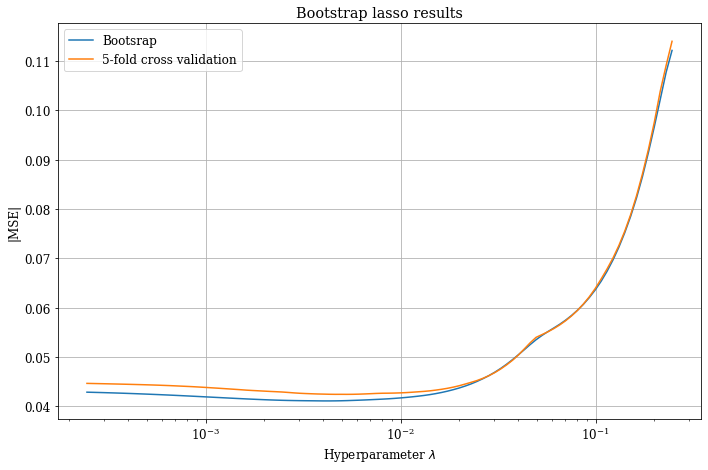

<IPython.core.display.Javascript object>

In [13]:
# Fixing font sizes of plots
fonts = {
    "font.family": "serif",
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
}

plt.rcParams.update(fonts)

# Log plot
plt.figure(figsize=(10, 6.7))
plt.semilogx(lambdas_lasso_bootstrap, mses_lasso_bootstrap, label="Bootsrap")
plt.semilogx(lambdas_lasso_cv, mses_lasso_cv, label="5-fold cross validation")
plt.xlabel(r"Hyperparameter $\lambda$")
plt.ylabel(r"|MSE|")
plt.title("Bootstrap lasso results")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Bootstrap and cross validation seem to estimate the error quite similarily. CV is probably a bit more realistic, as the error is a bit higher, but that i not important. The important thing is where the minimum is, and it seems to be almost the same for both methods.

# Task 1.5

To determine which features are nonlinear, I plot them all:

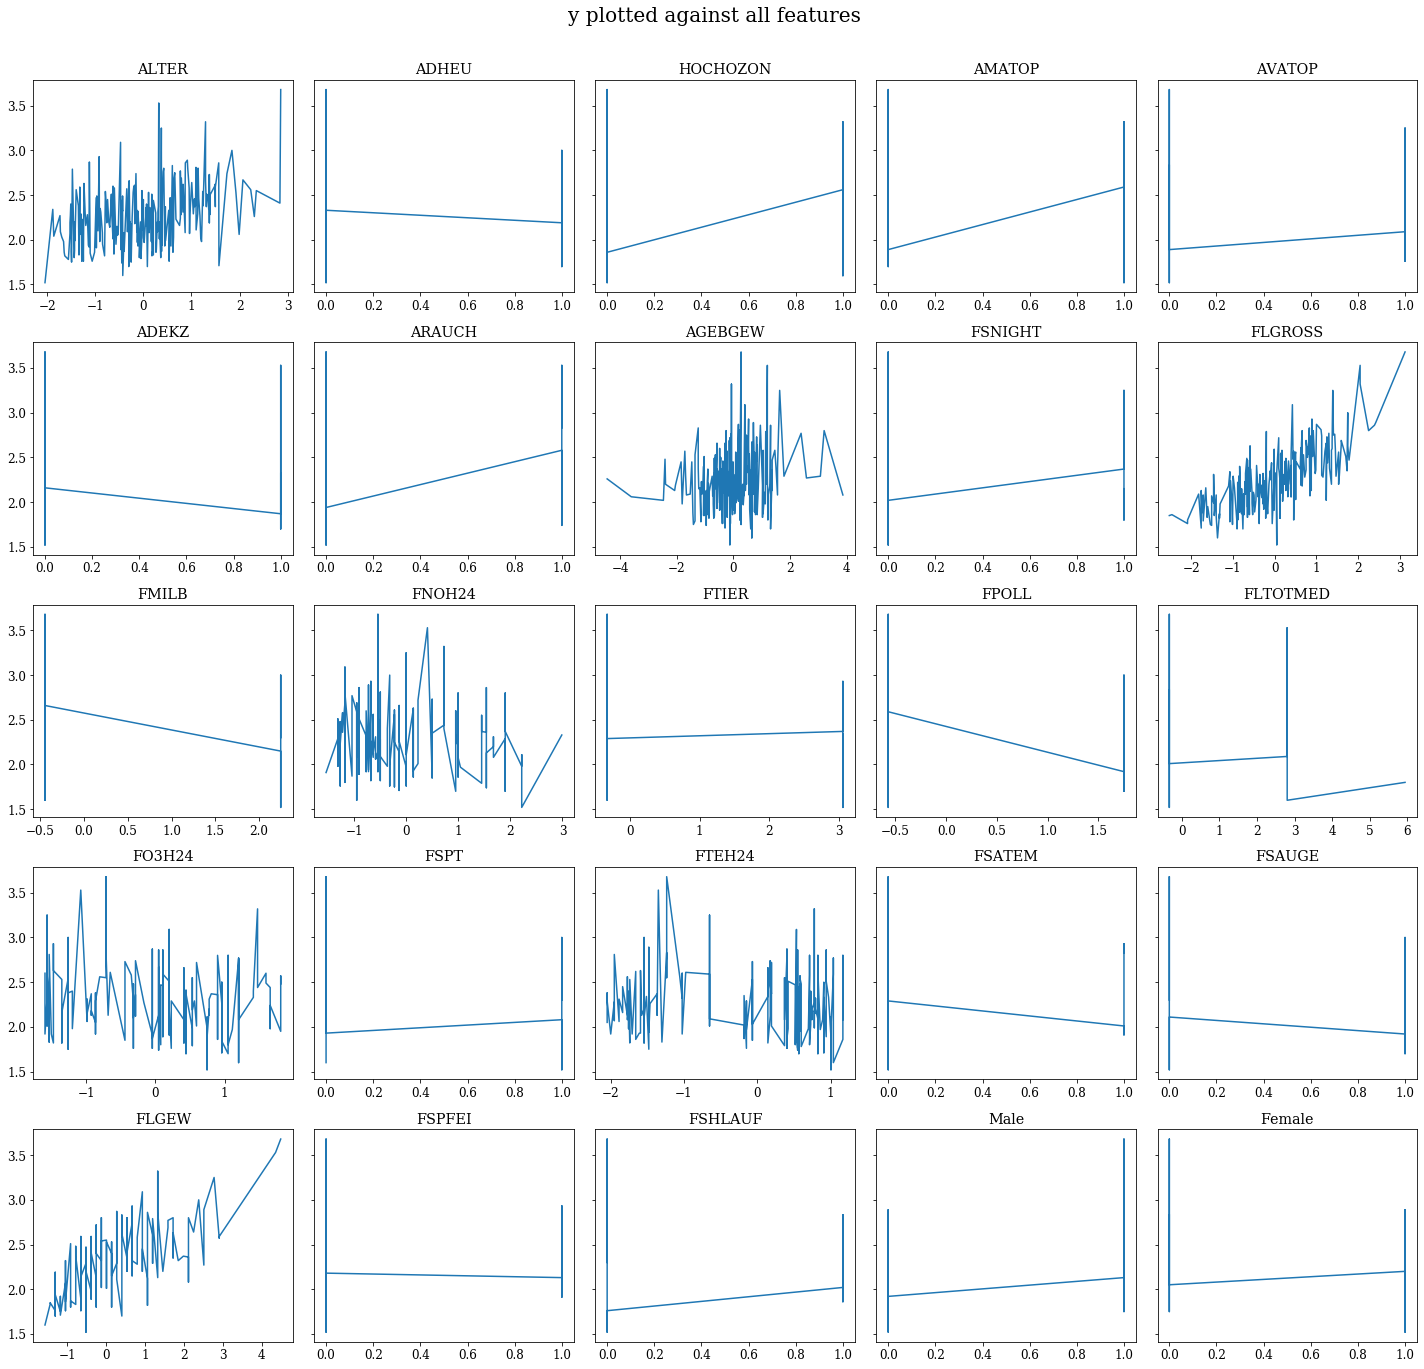

<IPython.core.display.Javascript object>

In [14]:
fig, axes = plt.subplots(5, 5, figsize=[20, 20], sharey=True)
axes = axes.ravel()
for i in range(X_train.values.shape[1]):
    sorted_indices = np.argsort(X_train.values[:, i])
    y_train.values[sorted_indices]
    axes[i].plot(X_train.values[:, i][sorted_indices], y_train.values[sorted_indices])
    axes[i].set_title(X_train.columns.values[i])
fig.suptitle("y plotted against all features", fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

FLGEW, FTEH24 and AGEBGEW to me seem nonlinear.

In [15]:
i  # Splines and betas. pygam.s is a spline, pyham.l is a linear feature.
features_gam = pygam.l(0)

nonlinear_features = ["FLGEW", "FTEH24", "AGEBGEW"]

# Setting up splines for all categorical values.
for i, feature in enumerate(X_train.columns.values[1:]):
    if feature in nonlinear_features:
        features_gam += pygam.l(i) + pygam.s(i)
    else:
        features_gam += pygam.l(i)

# Lambdas for ramdomized search of penalties.
lambdas = np.exp(np.random.rand(100, len(features_gam)) * 3 - 3)
# Fitting a GAM-model and searching for best hyperparameters lambda
gam = pygam.LinearGAM(features_gam).gridsearch(
    X_train.values, y_train.values, lam=lambdas
)

100% (100 of 100) |######################| Elapsed Time: 0:00:14 Time:  0:00:14


<IPython.core.display.Javascript object>

In [16]:
# R^2 score. There was a bug with pygam so I had to calculate it like this.
r2_test_gam = gam._estimate_r2(X_test, y_test)["explained_deviance"]
r2_train_gam = gam._estimate_r2(X_train, y_train)["explained_deviance"]
print(f"R^2 score test: {r2_test_gam:.2f}, R^2 score train: {r2_train_gam:.2f}")

R^2 score test: 0.61, R^2 score train: 0.69


<IPython.core.display.Javascript object>

This seems to make no improvement. I am wondering if something is implemented wrongly or if this was to be expected. 
Could perheps try many more penalties. The increased complexity may have lead to overfitting as seen on the difference between train and test $R^2$.

Next I test with adding higher orders of the nonlinear features.

In [17]:
# Reversing scale of training features, need this to get the second order features. Will scale them again after.
X_train_nonlinear = scaler.inverse_transform(
    X_train.loc[:, np.logical_not(np.isin(X_train.columns, categorical))]
)
# Reversing scale of testing features, need this to get the second order features. Will scale them again after.
X_test_nonlinear = scaler.inverse_transform(
    X_test.loc[:, np.logical_not(np.isin(X_test.columns, categorical))]
)
# Lists to save the nonlinear features and names
nonlinear_columns_train = []
nonlinear_columns_test = []
nonlinear_columns_name = []
# Looping over features
for i, name in enumerate(
    X_train.loc[:, np.logical_not(np.isin(X_train.columns, categorical))]
):
    # If feature is in nonlinear_features, add it to list of nonlinear features
    if name in nonlinear_features:
        nonlinear_columns_train.append(X_train_nonlinear[:, i] ** 2)
        nonlinear_columns_test.append(X_test_nonlinear[:, i] ** 2)
        nonlinear_columns_name.append(name + "^2")
# Creating columns with right dimensions out of second order features
nonlinear_columns_train = np.array(nonlinear_columns_train).T
nonlinear_columns_test = np.array(nonlinear_columns_test).T
# Scaling the nonlinear features
scaler_nonlinear = sklpre.StandardScaler()
nonlinear_columns_train = scaler_nonlinear.fit_transform(nonlinear_columns_train)
nonlinear_columns_test = scaler_nonlinear.transform(nonlinear_columns_test)
# Creating new dataframes containing the nonlinear features
X_train_nonlinear = pd.DataFrame(
    nonlinear_columns_train, columns=nonlinear_columns_name, index=X_train.index.values
)
X_test_nonlinear = pd.DataFrame(
    nonlinear_columns_test, columns=nonlinear_columns_name, index=X_test.index.values
)
# Creating new dataframes with all features, ready for fit
X_train_nonlinear = X_train.join(X_train_nonlinear)
X_test_nonlinear = X_test.join(X_test_nonlinear)

# Fitting OLS model
regressor_nonlinear = skllm.LinearRegression().fit(X_train_nonlinear, y_train)

# R2 scores
r2_score_nonlinear_train = regressor_nonlinear.score(X_train_nonlinear, y_train)
r2_score_nonlinear_test = regressor_nonlinear.score(X_test_nonlinear, y_test)
print(
    f"R2 score test:{r2_score_nonlinear_test:.2f}, train: {r2_score_nonlinear_train:.2f}"
)
# Printing table of p-values etc.
get_summary_linear_model(regressor_nonlinear, X_train_nonlinear, y_train)

R2 score test:0.59, train: 0.70


,Feature,$\beta_i$,$\pm$,p-values
0,Intercept,2.283576,0.026013,0.000000e+00
1,ALTER,0.029022,0.015601,6.403896e-02
2,ADHEU,-0.003816,0.055075,9.448193e-01
3,HOCHOZON,-0.063567,0.039314,1.071793e-01
4,AMATOP,-0.012845,0.031670,6.853928e-01
5,AVATOP,-0.003448,0.030885,9.112007e-01
6,ADEKZ,0.018731,0.034865,5.915742e-01
7,ARAUCH,0.059707,0.029440,4.362180e-02
8,AGEBGEW,0.056357,0.077606,4.684118e-01
9,FSNIGHT,-0.016917,0.046741,7.177097e-01


<IPython.core.display.Javascript object>

Seems to perform about equally to the GAM model. As we can see the p-values aren't very impressive for the new nonlinear features. They also have rather high uncertainties.

# Task 1.6
I can't find an implementation of component-wise boosting, so I will load R into my notebook and try my best there! I feel like R still has many more features than Python when it comes to lesser known statistical learning methods, so I think it is still good to learn the best of both worlds.

In [50]:
%load_ext rpy2.ipython
train_for_r = X_train.join(y_train)
test_for_r = X_test.join(y_test)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


<IPython.core.display.Javascript object>

First I fit a component_wise boost with splines!

In [35]:
%%R -i train_for_r -i test_for_r
library(compboost)
library(ggplot2)
spline_boost = boostSplines(data = train_for_r, target = "FFVC", loss = LossQuadratic$new(), trace=10)

  1/100: risk = 0.054
 10/100: risk = 0.037
 20/100: risk = 0.028
 30/100: risk = 0.024
 40/100: risk = 0.022
 50/100: risk = 0.02
 60/100: risk = 0.019
 70/100: risk = 0.018
 80/100: risk = 0.017
 90/100: risk = 0.017
100/100: risk = 0.016


Train 100 iterations in 0 Seconds.
Final risk based on the train set: 0.016



<IPython.core.display.Javascript object>

In [36]:
%%R
table(spline_boost$getSelectedBaselearner())


 AGEBGEW_spline    ALTER_spline    FLGEW_spline  FLGROSS_spline FLTOTMED_spline 
              3              14              19              28               3 
  FO3H24_spline   FTEH24_spline   Female_spline     Male_spline 
              3              11              15               4 


<IPython.core.display.Javascript object>

As we can see, not all features are chosen. The FLGROSS is chosen the most, which makes sense, as it had the lowest p-value in our original OLS model as well. 

Next I will do the same for linear regressors.

In [37]:
%%R
linear_boost = boostLinear(data = train_for_r, target = "FFVC", loss = LossQuadratic$new(), trace=10)

  1/100: risk = 0.055
 10/100: risk = 0.038
 20/100: risk = 0.03
 30/100: risk = 0.026
 40/100: risk = 0.024
 50/100: risk = 0.022
 60/100: risk = 0.022
 70/100: risk = 0.021
 80/100: risk = 0.021
 90/100: risk = 0.02
100/100: risk = 0.02


Train 100 iterations in 0 Seconds.
Final risk based on the train set: 0.02



<IPython.core.display.Javascript object>

In [38]:
%%R
linear_boost$getEstimatedCoef()

$ALTER_linear
              [,1]
[1,] -6.133737e-18
[2,]  1.308454e-02

$ARAUCH_linear
             [,1]
[1,] -0.003318719
[2,]  0.010161017

$FLGEW_linear
              [,1]
[1,] -2.163860e-16
[2,]  9.449943e-02

$FLGROSS_linear
              [,1]
[1,] -8.097660e-16
[2,]  1.436501e-01

$FMILB_linear
              [,1]
[1,]  1.570820e-17
[2,] -1.075807e-02

$FSPFEI_linear
              [,1]
[1,] -0.0008576529
[2,]  0.0151927082

$Female_linear
            [,1]
[1,]  0.07103375
[2,] -0.14803673

$offset
[1] 2.268669



<IPython.core.display.Javascript object>

More or less the same features seem to be selected here as well. FLGROSS having the largest coefficient (Male and female have higher, but they are binary and therefore act differently.)

# Task 1.7

Calculating the train and test MSE for all models:

In [23]:
def mean_squared_error(sklearn_model, X, y):
    """
    Function for computing MSE of scikit-learn models.
    """
    return ((sklearn_model.predict(X) - y) ** 2).mean()

<IPython.core.display.Javascript object>

In [24]:
# MSE train and test of OLS
print(
    f"OLS: train: {mean_squared_error(ols_reg, X_train, y_train):g}"
    + f"  test: {mean_squared_error(ols_reg, X_test, y_test):g}"
)
# MSE train and test of strict forward selection
print(
    f"Increased: train: {mean_squared_error(regressor_increased, X_increased_train, y_train):g}"
    + f"  test: {mean_squared_error(regressor_increased, X_increased_test, y_test):g}"
)
# MSE train and test of less strict forward selection
print(
    f"Increased less strict: train: {mean_squared_error(regressor_increased_less_strict, X_increased_train_less_strict, y_train):g}"
    + f"  test: {mean_squared_error(regressor_increased_less_strict, X_increased_test_less_strict, y_test):g}"
)
# MSE train and test of strict backward elimination
print(
    f"Reduced: train: {mean_squared_error(regressor_reduced, X_reduce_train, y_train):g}"
    + f"  test: {mean_squared_error(regressor_reduced, X_reduce_test, y_test):g}"
)
# MSE train and test of less strict backward elimination
print(
    f"Reduced less strict: train: {mean_squared_error(regressor_reduced_less_strict, X_reduce_train_less_strict, y_train):g}"
    + f"  test: {mean_squared_error(regressor_reduced_less_strict, X_reduce_test_less_strict, y_test):g}"
)
# MSE train and test for LASSO CV
print(
    f"LASSO CV: train: {mean_squared_error(lasso_cv, X_train, y_train):g}"
    + f"  test: {mean_squared_error(lasso_cv, X_test, y_test):g}"
)
# MSE train and test for LASSO bootstrap
print(
    f"LASSO bootstrap: train: {mean_squared_error(lasso_bootstrap, X_train, y_train):g}"
    + f"  test: {mean_squared_error(lasso_bootstrap, X_test, y_test):g}"
)
# MSE train and test for GAM
print(
    f"GAM: train: {mean_squared_error(gam, X_train, y_train):g}"
    + f"  test: {mean_squared_error(gam, X_test, y_test):g}"
)

OLS: train: 0.0358817  test: 0.0513415
Increased: train: 0.0407105  test: 0.050134
Increased less strict: train: 0.0407105  test: 0.050134
Reduced: train: 0.0395124  test: 0.0515099
Reduced less strict: train: 0.0377712  test: 0.0517113
LASSO CV: train: 0.0378755  test: 0.0516185
LASSO bootstrap: train: 0.0375187  test: 0.0514679
GAM: train: 0.035888  test: 0.0513726


<IPython.core.display.Javascript object>

In [56]:
%%R
library(MLmetrics)
print("Element-wise spline boosting:")
print("Train: ")
print(MSE(y_pred=data.matrix(spline_boost$predict(train_for_r)), y_true=data.matrix(train_for_r["FFVC"])))
print("Test: ")
#print(MSE(y_pred=data.matrix(spline_boost$predict(test_for_r)), y_true=data.matrix(test_for_r["FFVC"])))
#spline_boost$predict(test_for_r)
#test_for_r

[1] "Element-wise spline boosting:"
[1] "Train: "
[1] 0.03222611
[1] "Test: "


<IPython.core.display.Javascript object>

* OLS:                   train: test:
* Forward 1:             train: test:
* Forward 2:             train: test:
* Backward 3:            train: test:
* Backward 4:            train: test:
* LASSO CV:              train: test:
* LASSO Bootstrap:       train: test:
* GAM:                   train: test:
* OLS nonlinear:         train: test:
* Element boost splines: train: test:
* Element boost linear:  train: test:
* Elemement boost trees: train: test: